In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ft2font
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import itertools
from itertools import zip_longest
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse import dok_matrix
from scipy.sparse import block_diag
from scipy.sparse.linalg import eigsh
import scipy.linalg as la
import os
import Hamiltonian_definition as HD

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
save_path = "/home/costanza/UNIVERSITÀ/secondo semestre/MOLTI CORPI/dati/"

## Lattice definition

In [3]:
Lx, Ly = 4,4 # lattice dim
L=Lx*Ly
dim=2**(Lx*Ly)

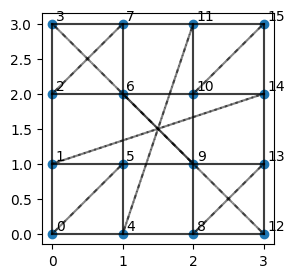

0 --> Nearest neighbors: [4, 3]  -- Next neighbor: [5]
1 --> Nearest neighbors: [5, 0]  -- Next neighbor: [14]
2 --> Nearest neighbors: [6, 1]  -- Next neighbor: [7]
3 --> Nearest neighbors: [7, 2]  -- Next neighbor: [12]
4 --> Nearest neighbors: [8, 7]  -- Next neighbor: [11]
5 --> Nearest neighbors: [9, 4]  -- Next neighbor: [0]
6 --> Nearest neighbors: [10, 5]  -- Next neighbor: [9]
7 --> Nearest neighbors: [11, 6]  -- Next neighbor: [2]
8 --> Nearest neighbors: [12, 11]  -- Next neighbor: [13]
9 --> Nearest neighbors: [13, 8]  -- Next neighbor: [6]
10 --> Nearest neighbors: [14, 9]  -- Next neighbor: [15]
11 --> Nearest neighbors: [15, 10]  -- Next neighbor: [4]
12 --> Nearest neighbors: [0, 15]  -- Next neighbor: [3]
13 --> Nearest neighbors: [1, 12]  -- Next neighbor: [8]
14 --> Nearest neighbors: [2, 13]  -- Next neighbor: [1]
15 --> Nearest neighbors: [3, 14]  -- Next neighbor: [10]


In [4]:
coor = HD.generate_lattice(Lx,Ly)
neighbors_indices = HD.index_nn(coor,Lx,Ly)
diag_indices = HD.index_nnn(coor,Lx,Ly)

HD.plot_lattice(coor,neighbors_indices,diag_indices)

## Chancing J1 J2

In [ ]:

"""
N=9
HN = HD.build_HN(Lx,Ly,N,J1,J2,neighbors_indices,diag_indices)
HN = HN.toarray()

eigvals, eigvecs = la.eigh(HN)
print(eigvals[0])"
"""


### Diagonalization

In [5]:
#angles = [(2*i-1)*np.pi/16 for i in range(6)]
#theta = angles[1:-1]
print(theta)



[0.39269908169872414]
9
10
11
12
13
14
15
16


In [ ]:
%%time
for i in range(len(theta)):
    print("-------------------------------")
    print(i, f"theta={theta[i]}")
    J1=np.sin(theta[i])
    J2=np.cos(theta[i])
    
    folder_name = f"J1={round(J1,2)}_J2={round(J2,2)}/"
    full_path = save_path + folder_name
    os.makedirs(full_path, exist_ok=True)

    HN = []
    for N in range(Lx*Ly+1):
        print(f'N={N}')
        HN.append(HD.build_HN(Lx,Ly,N,J1,J2,neighbors_indices,diag_indices))
        print(HN[N].shape)

        HN_dict = {}
        HN_dict[f'HN_{N}'] = HN[N].toarray()

        eigvals, eigvecs = la.eigh(HN_dict[f'HN_{N}'])
        print(f"finito di diagonalizzare HN_{N} alle", datetime.now())
        print("")
        
        folder_eig = f"eigvals block N={N}/"
        path = full_path + folder_eig
        os.makedirs(path, exist_ok=True)
        np.save(path+f"eigvals_N={N}", eigvals)
        np.save(path+f"eigvecs_N={N}", eigvecs)

-------------------------------
0 theta=0.39269908169872414
N=9
build_HN finito


IndexError: list index out of range

## Reading data

### Eigen values

#### J1=0, J2=1

/tmp/ipykernel_14031/2254583894.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


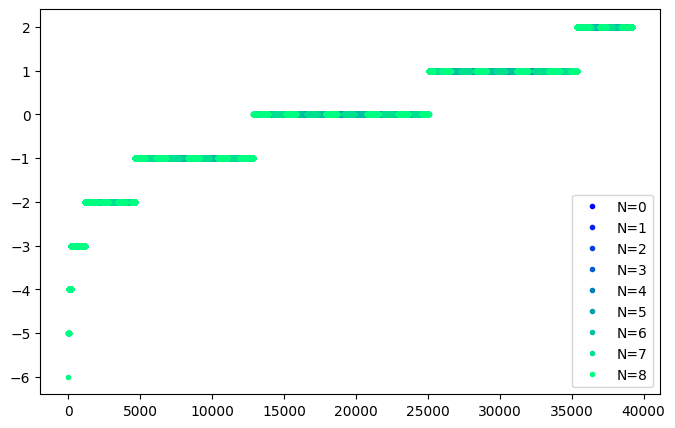

In [4]:
plt.figure(figsize=(8,5))
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 9))

all_eigvals = []
all_labels = []
for i in range(9):
    a=np.load(save_path+"J1=0.0_J2=1.0/"+f"eigvals block N={i}/"+f"eigvals_N={i}.npy")
    all_eigvals.extend(a)
    all_labels.extend([i]*len(a)) 

all_eigvals = np.array(all_eigvals)
all_labels = np.array(all_labels)
sorted_indices = np.argsort(all_eigvals)
all_eigvals_sorted = all_eigvals[sorted_indices]
all_labels_sorted = all_labels[sorted_indices]

for i in range(9):
    mask = all_labels_sorted == i
    plt.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i], label=f"N={i}")

plt.legend()
plt.show()

eigvals_0_1 = all_eigvals_sorted
labels_0_1 = all_labels_sorted

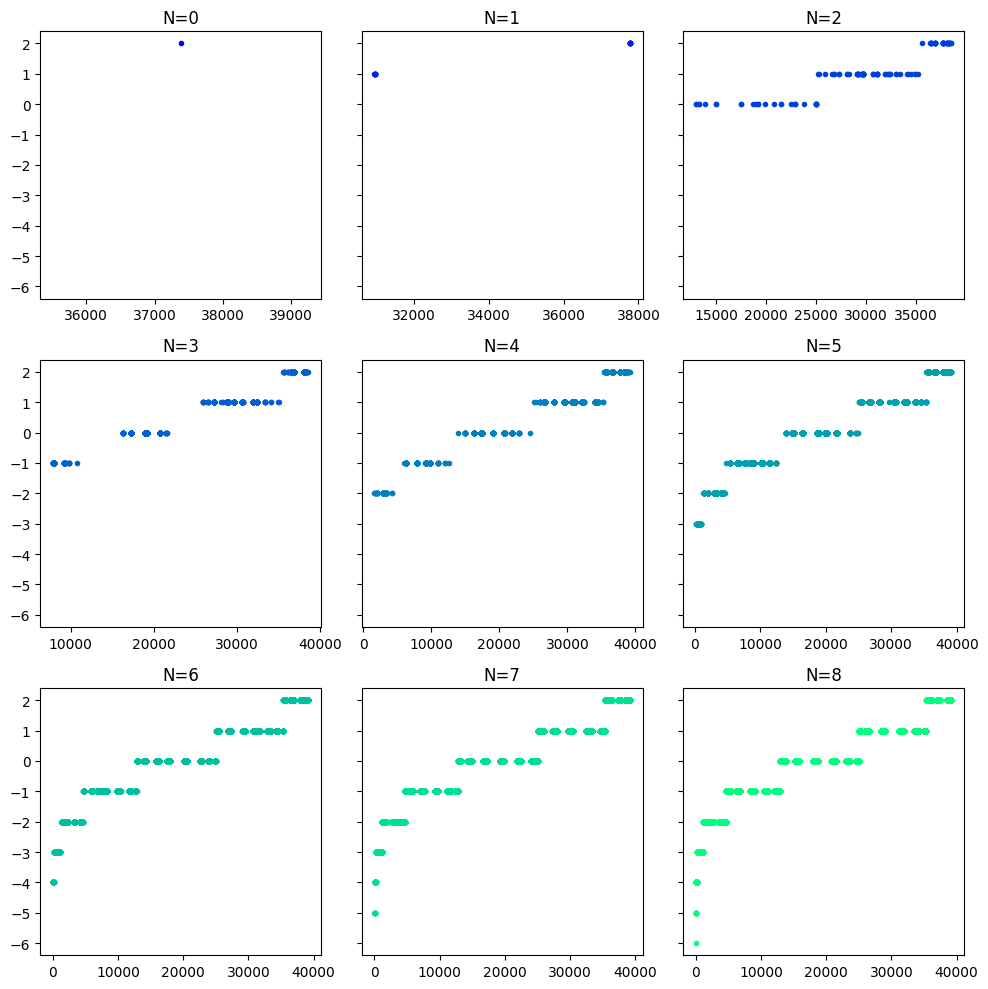

In [5]:

fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)

for i, ax in enumerate(axes.flatten()):
    mask = all_labels_sorted == i
    ax.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i])
    ax.set_title(f"N={i}")
plt.tight_layout()
plt.show()

#### J1=1, J2=0

/tmp/ipykernel_14031/3255430011.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


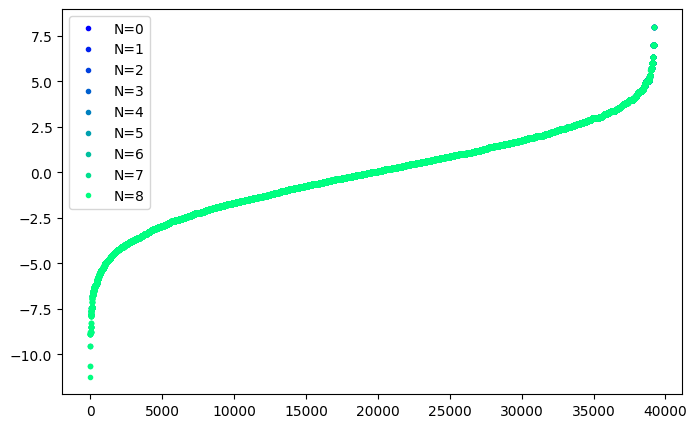

-11.228483208428862


In [6]:
plt.figure(figsize=(8,5))
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 9))

all_eigvals = []
all_labels = []
for i in range(9):
    a=np.load(save_path+"J1=1.0_J2=0.0/"+f"eigvals block N={i}/"+f"eigvals_N={i}.npy")
    all_eigvals.extend(a)
    all_labels.extend([i]*len(a)) 

all_eigvals = np.array(all_eigvals)
all_labels = np.array(all_labels)
sorted_indices = np.argsort(all_eigvals)
all_eigvals_sorted = all_eigvals[sorted_indices]
all_labels_sorted = all_labels[sorted_indices]

for i in range(9):
    mask = all_labels_sorted == i
    plt.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i], label=f"N={i}")

plt.legend()
plt.show()
print(all_eigvals_sorted[0])

eigvals_1_0 = all_eigvals_sorted
labels_1_0 = all_labels_sorted

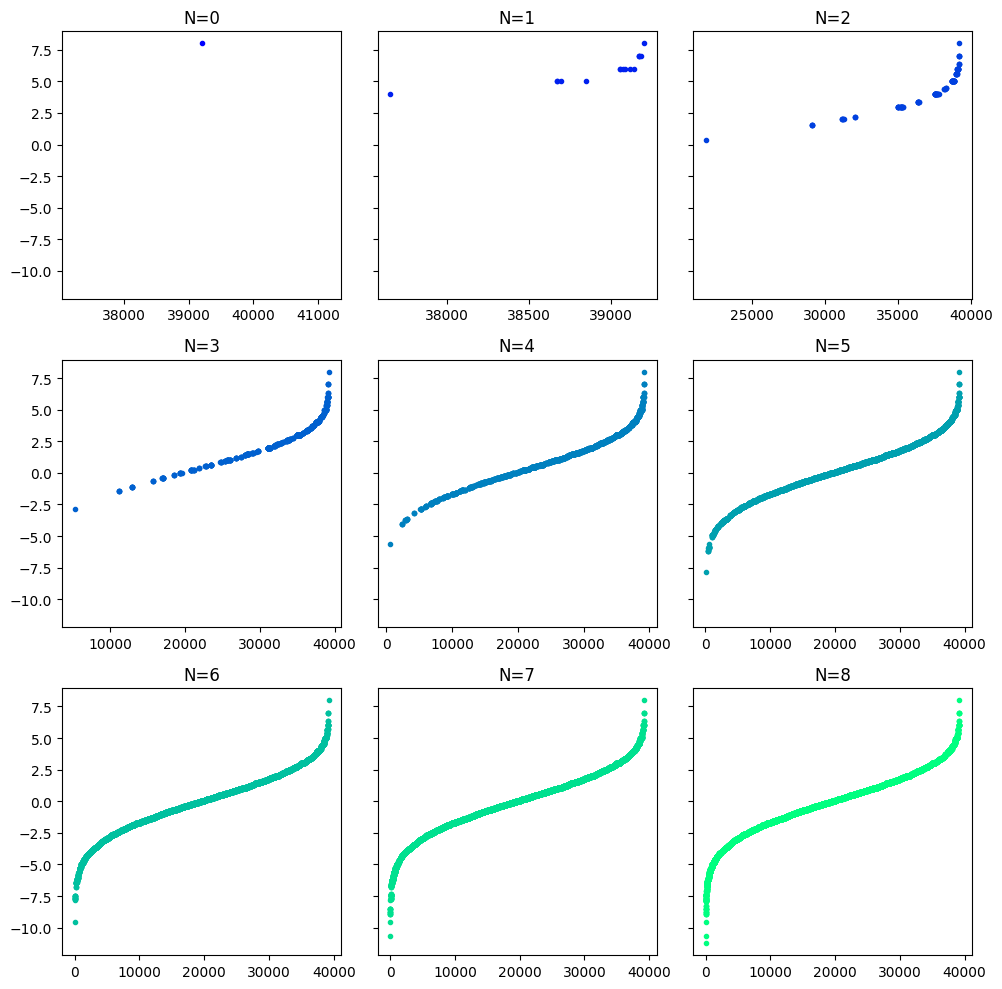

In [7]:
fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)

for i, ax in enumerate(axes.flatten()):
    mask = all_labels_sorted == i
    ax.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i])
    ax.set_title(f"N={i}")
plt.tight_layout()
plt.show()

#### Other values of J1 and J2

/tmp/ipykernel_14031/484868109.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


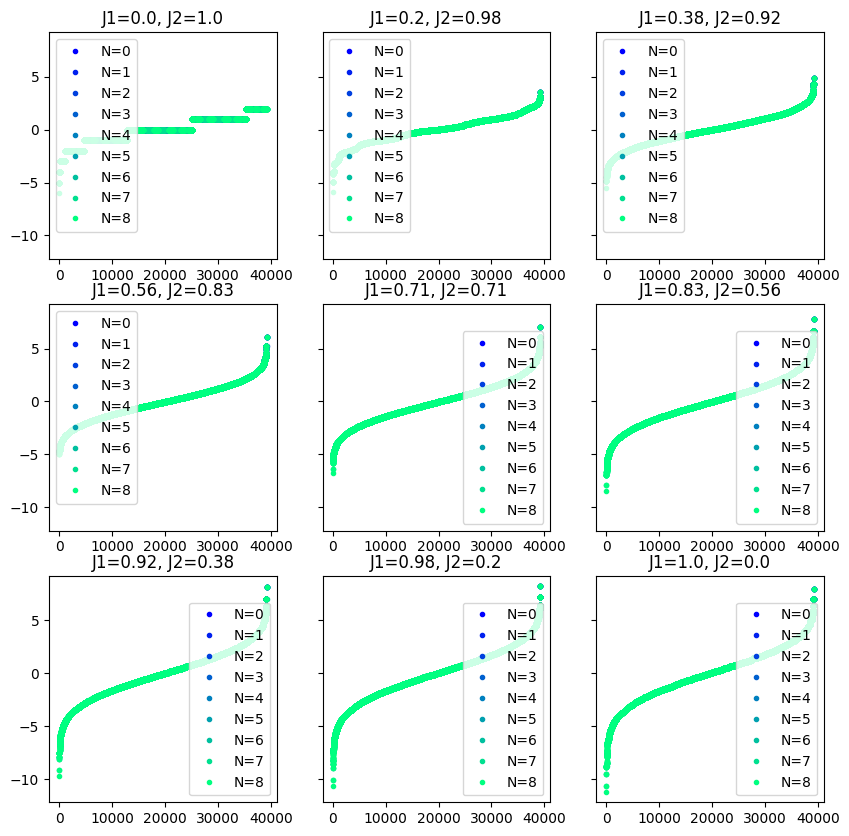

In [8]:
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/"]
all_theta = [i*np.pi/16 for i in range(9)]

eigvals_dict = {}
labels_dict = {}

fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)
for F, ax in enumerate(axes.flatten()):

    colormap = get_cmap("winter")
    colors = colormap(np.linspace(0, 1, 9))

    all_eigvals = []
    all_labels = []
    for i in range(9):
        eigvals = np.load(save_path+folder[F]+f"eigvals block N={i}/"+f"eigvals_N={i}.npy")
        all_eigvals.extend(eigvals)
        all_labels.extend([i]*len(eigvals)) 

    all_eigvals = np.array(all_eigvals)
    all_labels = np.array(all_labels)

    sorted_indices = np.argsort(all_eigvals)
    all_eigvals_sorted = all_eigvals[sorted_indices]
    all_labels_sorted = all_labels[sorted_indices]

    for i in range(9):
        mask = all_labels_sorted == i
        ax.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i], label=f"N={i}")
    J1 = np.sin(all_theta[F])
    J2 = np.cos(all_theta[F])
    ax.set_title(f'J1={round(J1,2)}, J2={round(J2,2)}')
    ax.legend()

    eigvals_dict[f'all_theta_{F}'] = all_eigvals_sorted
    labels_dict[f'all_theta_{F}'] = all_labels_sorted

plt.show()

J1=1.0_J2=0.0/


/tmp/ipykernel_14031/2989311106.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


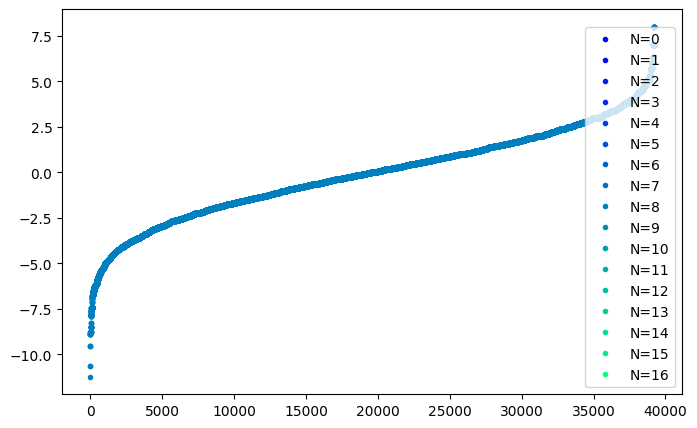

In [9]:
#plotting of single spectrum
F=8
print(folder[F])
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 17))
plt.figure(figsize=(8,5))
for i in range(17):
    mask = labels_dict[f'all_theta_{F}'] == i
    plt.plot(np.where(mask)[0],eigvals_dict[f'all_theta_{F}'][mask], '.', color=colors[i], label=f"N={i}")

plt.legend()

J1=0.56_J2=0.83/


/tmp/ipykernel_14031/2351494737.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


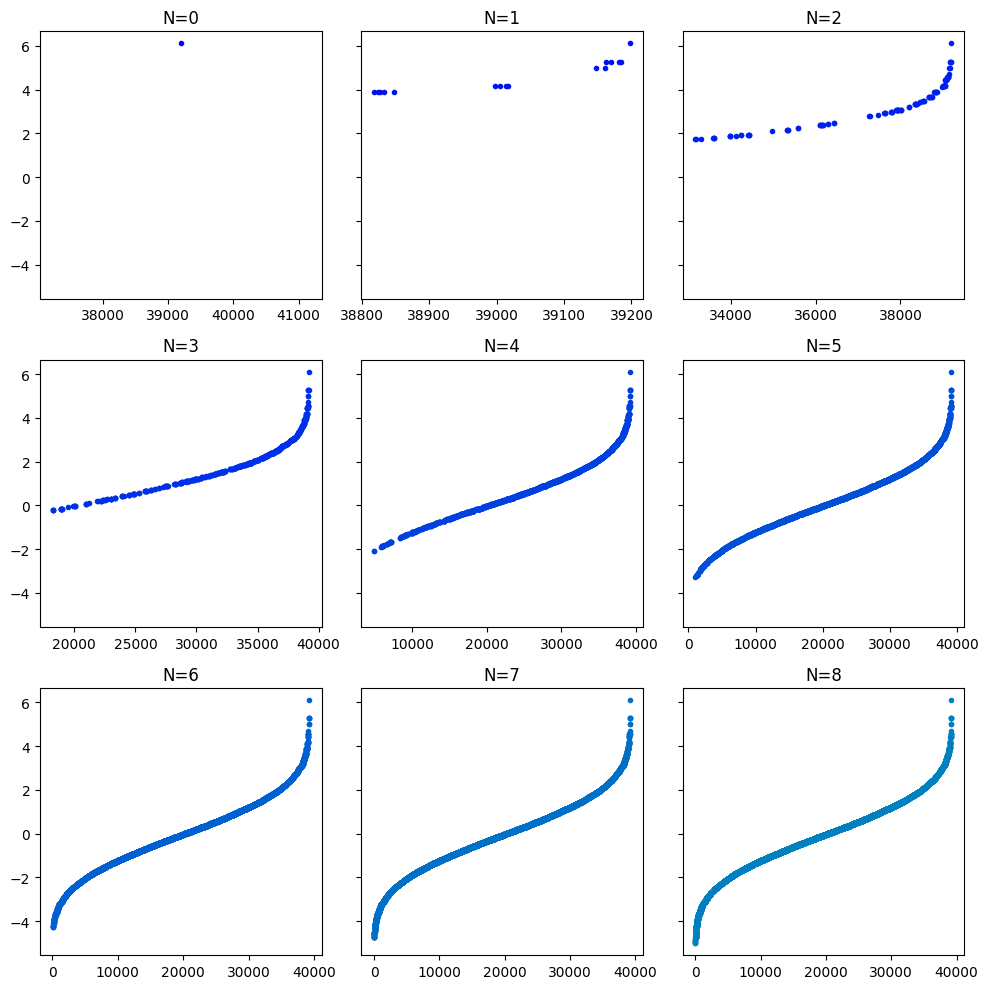

In [11]:
fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)
F=3
print(folder[F])
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 17))
for i, ax in enumerate(axes.flatten()):
    mask = labels_dict[f'all_theta_{F}'] == i
    ax.plot(np.where(mask)[0], eigvals_dict[f'all_theta_{F}'][mask], '.', color=colors[i])
    ax.set_title(f"N={i}")
plt.tight_layout()
plt.show()

## Analysis

In [15]:
"""
JUST TO REMEMBER
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/"]
all_theta = [i*np.pi/16 for i in range(9)]
eigvals_dict[f'all_theta_{F}'] = all_eigvals_sorted
labels_dict[f'all_theta_{F}'] = all_labels_sorted"
"""

'\nJUST TO REMEMBER\nfolder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/","J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/"]\nall_theta = [i*np.pi/16 for i in range(9)]\neigvals_dict[f\'all_theta_{F}\'] = all_eigvals_sorted\nlabels_dict[f\'all_theta_{F}\'] = all_labels_sorted"\n'

### Plotting energies changing J1, J2

/tmp/ipykernel_14031/3634350713.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


Text(0, 0.5, 'eigvals')

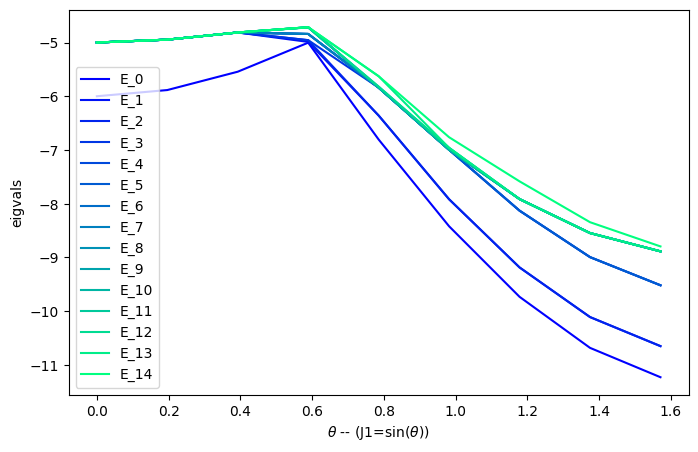

In [19]:
number = 15 #how many eigen values do you want?
plt.figure(figsize=(8,5))
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, number))
for j in range(number):
    energy = [eigvals_dict[f'all_theta_{i}'][j] for i in range(len(all_theta))]
    plt.plot(all_theta, energy, label=f'E_{j}',color=colors[j])
    plt.legend()
plt.xlabel(r'$\theta$ -- (J1=sin($\theta$))')
plt.ylabel('eigvals')
#plt.xlim(0.4,0.8)
#plt.ylim(-6,-4)

### gap changing J1, J2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0 J1=0.0, J2=1.0, J1/J2=0.0
0.2 J1=0.2, J2=0.98, J1/J2=0.2
0.39 J1=0.38, J2=0.92, J1/J2=0.41
0.59 J1=0.56, J2=0.83, J1/J2=0.67
0.79 J1=0.71, J2=0.71, J1/J2=1.0
0.98 J1=0.83, J2=0.56, J1/J2=1.5
1.18 J1=0.92, J2=0.38, J1/J2=2.41
1.37 J1=0.98, J2=0.2, J1/J2=5.03
1.57 J1=1.0, J2=0.0, J1/J2=1.6331239353195368e+16


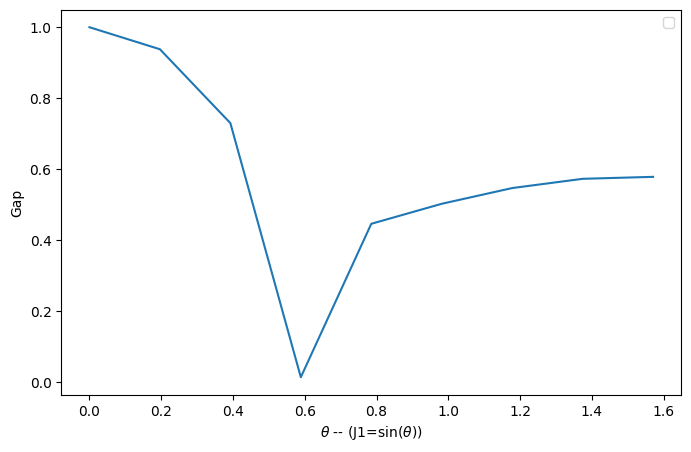

In [26]:

plt.figure(figsize=(8,5))
GS = [eigvals_dict[f'all_theta_{i}'][0] for i in range(len(all_theta))]
E1 = [eigvals_dict[f'all_theta_{i}'][1] for i in range(len(all_theta))]
J1 = np.sin(all_theta)
J2 = np.cos(all_theta)
for i in range(len(all_theta)):
    print(round(all_theta[i],2), f'J1={round(J1[i],2)}, J2={round(J2[i],2)}, J1/J2={round(J1[i]/J2[i],2)}')
plt.plot(all_theta, np.array(E1)-np.array(GS))
plt.xlabel(r'$\theta$ -- (J1=sin($\theta$))')
plt.ylabel('Gap')
plt.legend()

### Correlation

In [5]:
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/"]

In [7]:
# loading of the eigen vectors
F = 0 #which folder? ie which values of J1 and J2
N = 7 #which block? ie value of Sz total
print(folder[F])
eigvecs = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvecs_N={N}.npy")
print(eigvecs.shape)

J1=0.0_J2=1.0/
(11440, 11440)


In [8]:
psi1 = eigvecs[0]
psi2 = eigvecs[0]

SzSz_nn_exval, SzSz_nnn_exval = HD.spin_corr(Lx,Ly,psi1,psi2,N,neighbors_indices,diag_indices)

print("nearest neighbor correlation", SzSz_nn_exval)
print("next neighbor correlation", SzSz_nnn_exval)


-0.36883275274791366 -0.21816384196094724
16.0
8.0
nearest neighbor correlation -0.06915614114023381
next neighbor correlation -0.0818114407353552
